In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd

In [2]:
def pickle_to_array(pickle_file):
    arrays = {}
    dat = np.load(pickle_file, allow_pickle=True)
    for k in dat.keys():
        arrays[k] = dat[k]
    print("Total number of arrays: ", len(arrays))
    return arrays

def gaze_array_to_csv(gaze_arrays, session_folder):
    columns = ['norm_pos_x', 'norm_pos_y', 'confidence', 'timestamp']
    gaze_df = pd.DataFrame(index=range(len(gaze_arrays["gaze_binocular"])), columns=columns)
    for i in range(len(gaze_arrays["gaze_binocular"])):
        gaze_df["norm_pos_x"].loc[i] = gaze_arrays["gaze_binocular"][i]["norm_pos"][0]
        gaze_df["norm_pos_y"].loc[i] = gaze_arrays["gaze_binocular"][i]["norm_pos"][1]
        gaze_df["confidence"].loc[i] = gaze_arrays["gaze_binocular"][i]["confidence"]
        gaze_df["timestamp"].loc[i] = gaze_arrays["gaze_binocular"][i]["timestamp"]
    gaze_df.to_csv(session_folder + "/gaze_2D_PL.csv")
    return gaze_df

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def pixels_to_angle_x(array):
    return (array - horizontal_pixels/2) * ratio_x

def pixels_to_angle_y(array):
    return (array - vertical_pixels/2) * ratio_y


In [3]:
horizontal_pixels = 2048
vertical_pixels = 1536
horizontal_FOV = 119.4
vertical_FOV = 82.0

In [4]:
session_folder = "/home/veddy06/ownCloud/vedbcloud0/processed/gaze_pilot/2020_09_28_20_53_15"
# data_folder = "/home/veddy06/ownCloud/vedbcloud0/staging/2020_09_28_20_53_15"

In [5]:
gaze_file = session_folder + "/PL_binocular_2D-PL_gaze.npz"
marker_file = session_folder +"/PL_binocular_2D-PL_calibration_ref_pos.npz"
left_pupil_file = session_folder + "/PL_binocular_2D-PL_pupil_pos_left.npz"
right_pupil_file = session_folder + "/PL_binocular_2D-PL_pupil_pos_right.npz"

In [6]:
gaze_arrays = pickle_to_array(gaze_file)

right_pupil_arrays = pickle_to_array(right_pupil_file)

left_pupil_arrays = pickle_to_array(left_pupil_file)

marker_arrays = pickle_to_array(marker_file)

Total number of arrays:  1
Total number of arrays:  8
Total number of arrays:  8
Total number of arrays:  4


In [7]:
len(gaze_arrays["gaze_binocular"])

72650

In [8]:
gaze_arrays["gaze_binocular"][0].keys()

dict_keys(['topic', 'norm_pos', 'confidence', 'timestamp', 'base_data'])

In [9]:
if not os.path.exists(session_folder + "/gaze_2D_PL.csv"):
    print("Creating the gaze.csv file")
    gaze_df = gaze_array_to_csv(gaze_arrays, session_folder)
else:
    print("gaze.csv exits, reading ...")
    gaze_df = pd.read_csv(session_folder + "/gaze_2D_PL.csv")

gaze.csv exits, reading ...


In [10]:
gaze_df.head()

,Unnamed: 0,norm_pos_x,norm_pos_y,confidence,timestamp
0,0,0.569833,0.618569,0.990000,36296.782306
1,1,0.570815,0.621526,0.893512,36296.830720
2,2,0.570892,0.623275,0.702916,36296.854927
3,3,0.571158,0.624480,0.818595,36296.887203
4,4,0.571841,0.624666,0.963921,36296.903342


In [11]:
ratio_x = horizontal_FOV/horizontal_pixels
ratio_y = vertical_FOV/vertical_pixels

gaze_norm_x = gaze_df.iloc[:].norm_pos_x.values
gaze_norm_y = gaze_df.iloc[:].norm_pos_y.values

gaze_pixel_x = gaze_norm_x * horizontal_pixels
gaze_pixel_y = gaze_norm_y * vertical_pixels

print('gazeX shape = ', gaze_pixel_x.shape)
print('gazeY shape = ',gaze_pixel_y.shape)

gaze_az = pixels_to_angle_x(gaze_pixel_x)
gaze_el = pixels_to_angle_y(gaze_pixel_y)

marker_az = pixels_to_angle_x(marker_arrays["norm_pos"][:,0]*horizontal_pixels)
marker_el = pixels_to_angle_y(marker_arrays["norm_pos"][:,1]*vertical_pixels)

print('markerX shape = ', marker_az.shape)
print('markerY shape = ',marker_el.shape)


gazeX shape =  (72650,)
gazeY shape =  (72650,)
markerX shape =  (1783,)
markerY shape =  (1783,)


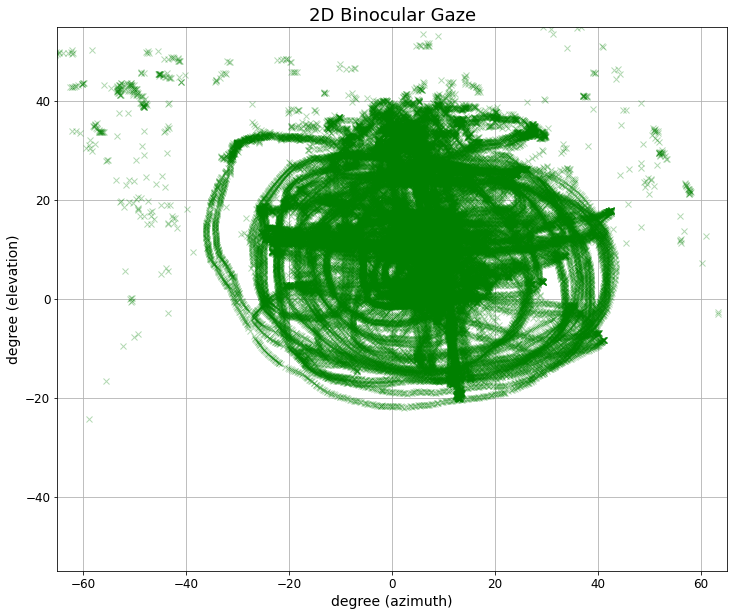

In [12]:
plt.figure(figsize=(12,10))
plt.plot(gaze_az, gaze_el, 'gx', alpha = 0.3)
plt.title("2D Binocular Gaze", fontsize=18)
plt.xlabel("degree (azimuth)", fontsize = 14)
plt.ylabel("degree (elevation)", fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-65,65)
plt.ylim(-55,55)
plt.grid(True)
plt.show()
#plt.savefig(os.getcwd()+"/average_fft_pupil.png", dpi=150)

In [13]:
marker_arrays.keys()

dict_keys(['location', 'norm_pos', 'size', 'timestamp'])

In [14]:
print(marker_arrays["norm_pos"].shape)
print(marker_arrays["timestamp"].shape)


(1783, 2)
(1783,)


In [15]:
def time_stamp_to_index(ts, time_stamp_array):
    index = np.argmin(np.abs((time_stamp_array - ts).astype(float)))
    return index


In [16]:
gaze_timestamp = gaze_df["timestamp"].values[:]

In [17]:

gaze_index = []
for timestamp in marker_arrays["timestamp"]:
    gaze_index.append(time_stamp_to_index(timestamp,gaze_timestamp))

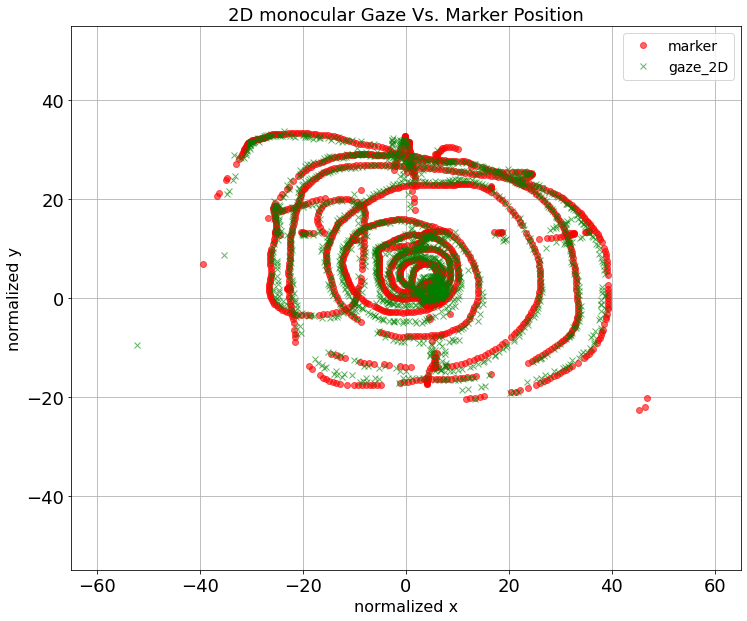

In [18]:
plt.figure(figsize=(12,10))
# plt.plot(marker_arrays["norm_pos"][:,0], marker_arrays["norm_pos"][:,1], 'ro', alpha = 0.6, label="marker")
plt.plot(marker_az, marker_el, 'ro', alpha = 0.6, label="marker")
plt.plot(gaze_az[gaze_index], gaze_el[gaze_index], 'xg', alpha = 0.6, label="gaze_2D")
plt.title("2D monocular Gaze Vs. Marker Position", fontsize=18)
plt.xlabel("normalized x", fontsize = 16)
plt.ylabel("normalized y", fontsize = 16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.xlim(-65,65)
plt.ylim(-55,55)
plt.legend(fontsize=14)
# plt.savefig("_gaze_marker.png", dpi=150, transparent=False)
plt.show()


In [19]:
plt.close()

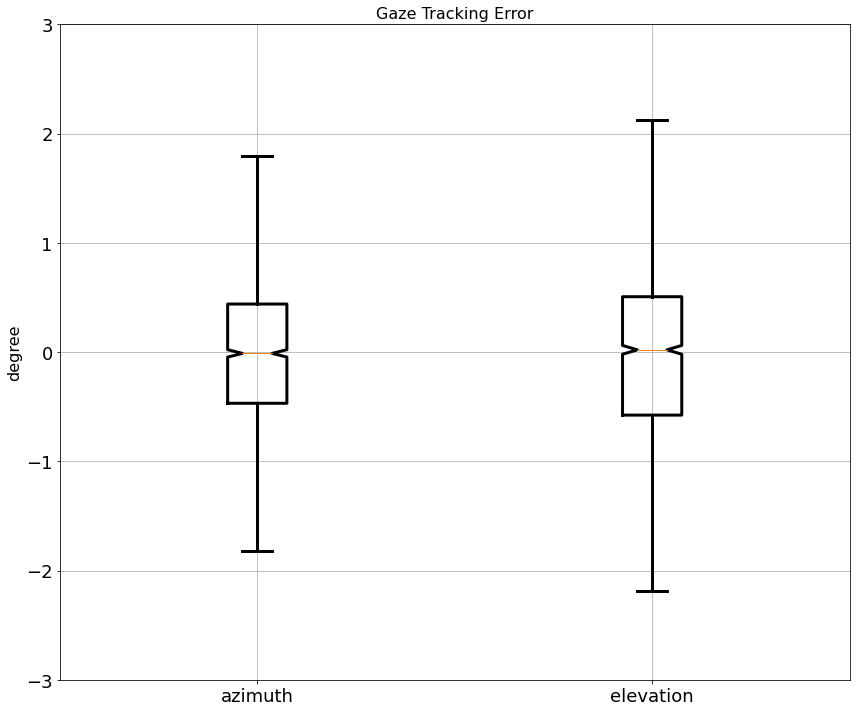

In [20]:
plt.figure(figsize=(12,10))
diff_az = marker_az - gaze_az[gaze_index]
diff_el = marker_el - gaze_el[gaze_index]


#plt.boxplot(diff_r_az, notch=True, showfliers=False)
boxprops = dict(linestyle='-', linewidth=3)
whiskerprops = dict(linestyle='-', linewidth=3)
capprops = dict(linestyle='-', linewidth=3)
plt.boxplot([diff_az, diff_el,], boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops
            ,notch=True, showfliers=False)
plt.title("Gaze Tracking Error", fontsize = 16)
plt.ylabel("degree", fontsize = 16)
plt.xticks([1,2],["azimuth", "elevation"], fontsize = 18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.ylim(-3,3)
plt.tight_layout()
plt.savefig("_2d_gaze_error.png", dpi=150, transparent=False)
plt.show()